In [11]:
# -------------------------------------------------
# Deliverable 3: Classification, Clustering & Pattern Mining
# -------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [20]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
# -----------------------------
# 1. Load Dataset
# -----------------------------
df = pd.read_csv("hour.csv")
df['dteday'] = pd.to_datetime(df['dteday'])

# Feature engineering
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year
df['hour_bin'] = pd.cut(df['hr'], bins=[-1,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])

# Drop unnecessary columns
df_model = df.drop(['instant','dteday','atemp','casual','registered'], axis=1)



In [14]:
# -----------------------------
# 2. Classification: Binning cnt
# -----------------------------
# Convert cnt into 3 categories: Low, Medium, High demand
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df_model['cnt_category'] = kbins.fit_transform(df_model[['cnt']]).astype(int)
df_model['cnt_category'] = df_model['cnt_category'].map({0:'Low',1:'Medium',2:'High'})

# Features and target
X = df_model.drop(['cnt','cnt_category'], axis=1)
y = df_model['cnt_category']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['season','weathersit','weekday','hr','month','hour_bin'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling for k-NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [15]:
# -----------------------------
# 3. Classification Models
# -----------------------------
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# k-NN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)


In [16]:
# -----------------------------
# 4. Hyperparameter Tuning: Decision Tree
# -----------------------------
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1_macro')
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)


--- Decision Tree ---
Accuracy: 0.8383199079401611
F1 Score: 0.839044658703283
Classification Report:
               precision    recall  f1-score   support

        High       0.85      0.86      0.86      1160
         Low       0.90      0.88      0.89      1150
      Medium       0.76      0.77      0.77      1166

    accuracy                           0.84      3476
   macro avg       0.84      0.84      0.84      3476
weighted avg       0.84      0.84      0.84      3476



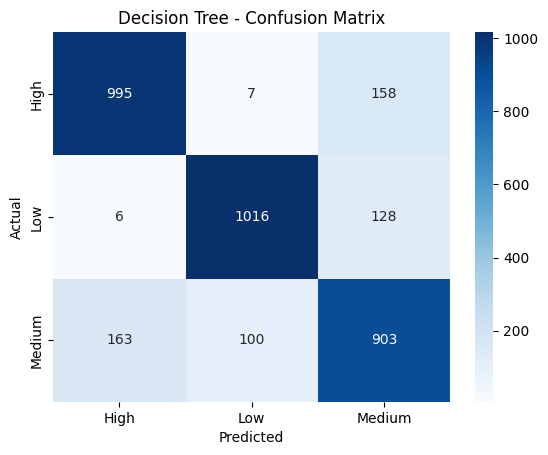

--- k-NN ---
Accuracy: 0.8023590333716916
F1 Score: 0.8027695686261259
Classification Report:
               precision    recall  f1-score   support

        High       0.78      0.86      0.82      1160
         Low       0.90      0.85      0.87      1150
      Medium       0.73      0.70      0.71      1166

    accuracy                           0.80      3476
   macro avg       0.80      0.80      0.80      3476
weighted avg       0.80      0.80      0.80      3476



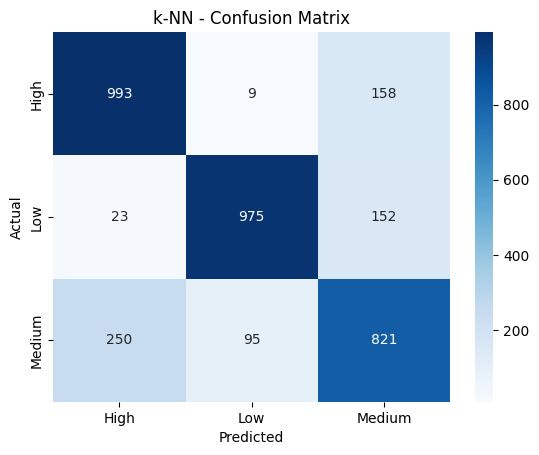

--- Tuned Decision Tree ---
Accuracy: 0.8457997698504027
F1 Score: 0.8470745590366544
Classification Report:
               precision    recall  f1-score   support

        High       0.86      0.87      0.86      1160
         Low       0.93      0.87      0.90      1150
      Medium       0.76      0.80      0.78      1166

    accuracy                           0.85      3476
   macro avg       0.85      0.85      0.85      3476
weighted avg       0.85      0.85      0.85      3476



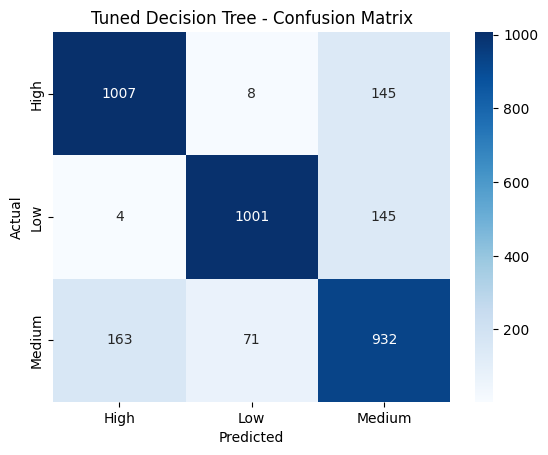

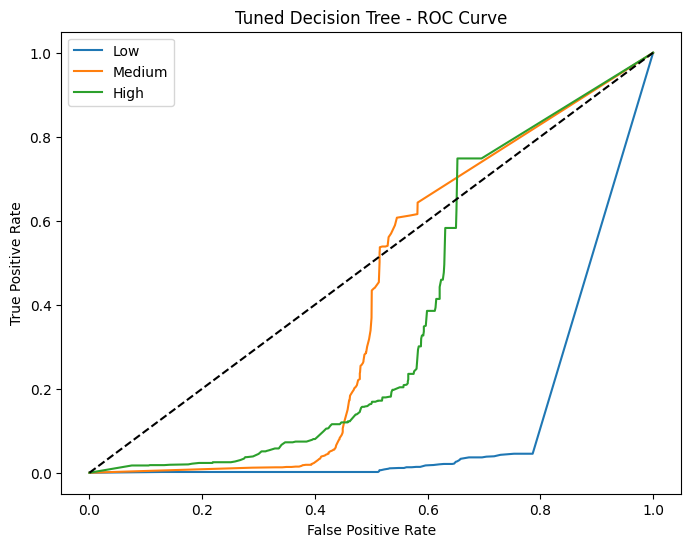

In [17]:
# -----------------------------
# 5. Evaluation Metrics
# -----------------------------
def evaluate_classification(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

evaluate_classification(y_test, y_pred_dt, "Decision Tree")
evaluate_classification(y_test, y_pred_knn, "k-NN")
evaluate_classification(y_test, y_pred_best_dt, "Tuned Decision Tree")

# ROC Curve (One-vs-Rest for multiclass)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_test_bin = label_binarize(y_test, classes=['Low','Medium','High'])

# Decision Tree ROC
y_score_dt = best_dt.predict_proba(X_test)
plt.figure(figsize=(8,6))
for i, cls in enumerate(['Low','Medium','High']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score_dt[:,i])
    plt.plot(fpr, tpr, label=f"{cls}")
plt.plot([0,1],[0,1],'k--')
plt.title("Tuned Decision Tree - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



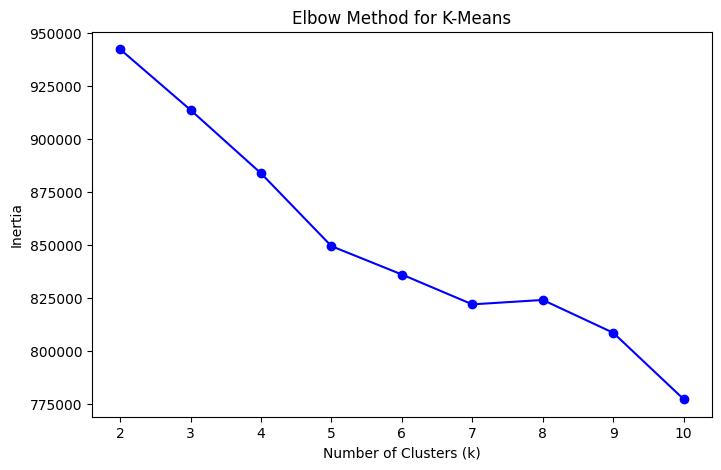

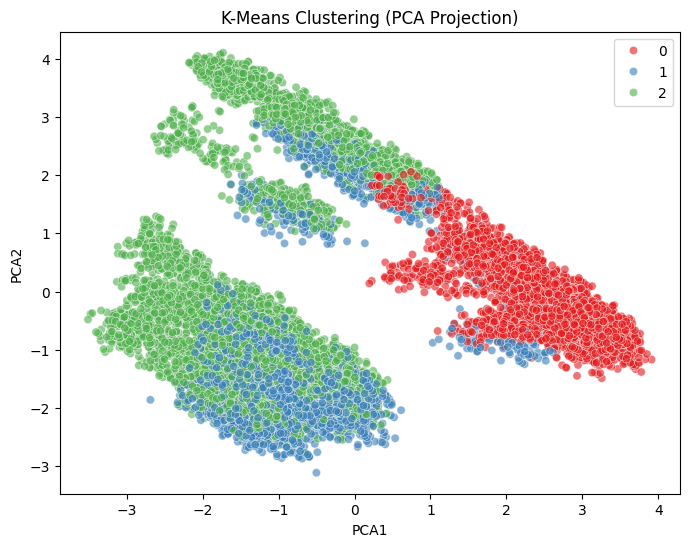

In [18]:
# -----------------------------
# 6. Clustering: K-Means
# -----------------------------
X_cluster = X.copy()
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Optimal number of clusters using Elbow Method
inertia = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2,11), inertia, 'o-', color='blue')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()

# Fit K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster_scaled)
X_cluster['Cluster'] = clusters

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_cluster_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=clusters, palette='Set1', alpha=0.6)
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


/tmp/ipython-input-1469032527.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trans_df_enc = trans_df_enc.applymap(lambda x: 1 if x >= 1 else 0)  # Force binary values


Top 10 Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


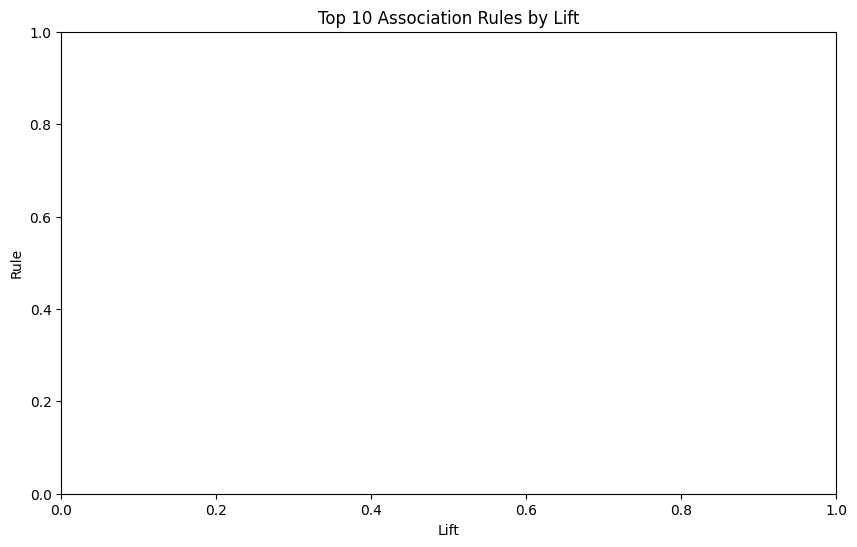

In [19]:
# -----------------------------
# 7. Association Rule Mining: Apriori (Corrected)
# -----------------------------
# Select categorical features
df_apriori = df.copy()
df_apriori['hour_bin'] = df_apriori['hour_bin'].astype(str)
df_apriori['season'] = df_apriori['season'].astype(str)
df_apriori['weathersit'] = df_apriori['weathersit'].astype(str)
df_apriori['weekday'] = df_apriori['weekday'].astype(str)

# Keep only relevant columns
trans_df = df_apriori[['season','weathersit','weekday','hour_bin']]

# One-hot encode to ensure binary (0/1) values
trans_df_enc = pd.get_dummies(trans_df)
trans_df_enc = trans_df_enc.applymap(lambda x: 1 if x >= 1 else 0)  # Force binary values

# Run Apriori
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(trans_df_enc, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules_sorted = rules.sort_values('lift', ascending=False).head(10)

# Display top rules
print("Top 10 Association Rules:")
print(rules_sorted[['antecedents','consequents','support','confidence','lift']])

# Visualize top rules
plt.figure(figsize=(10,6))
sns.barplot(
    x=rules_sorted['lift'],
    y=rules_sorted['antecedents'].astype(str) + " -> " + rules_sorted['consequents'].astype(str)
)
plt.title("Top 10 Association Rules by Lift")
plt.xlabel("Lift")
plt.ylabel("Rule")
plt.show()
